In [2]:
# Import Custom Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix, log_loss, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
%matplotlib inline

In [3]:
import boto3
from io import BytesIO
import pandas as pd
import numpy as np

def load_pitch_data_from_s3(csv_files, number_of_rows=None, bucket='qualitycontact'):
    '''
    Function to take a list of loan data CSV files that stored in an AWS S3 bucket and load and
    concatenate them into one dataframe.
    Args:
        csv_files (list or tuple): List of CSV files that contain the data. Below is a tuple of the names of the
        available files from Lending Club as of April 2019.
        ('LoanStats3a_securev1.csv', 'LoanStats3b_securev1.csv', 'LoanStats3c_securev1.csv', 'LoanStats3d_securev1.csv',
         'LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv', 'LoanStats_securev1_2016Q3.csv',
         'LoanStats_securev1_2016Q4.csv', 'LoanStats_securev1_2017Q1.csv', 'LoanStats_securev1_2017Q2.csv', 
         'LoanStats_securev1_2017Q3.csv', 'LoanStats_securev1_2017Q4.csv', 'LoanStats_securev1_2018Q1.csv',
         'LoanStats_securev1_2018Q2.csv', 'LoanStats_securev1_2018Q3.csv', 'LoanStats_securev1_2018Q4.csv')
        columns (list or tuple): List of column names that should be used in the dataframe. Certain columns should be
        excluded due to the fact they would not have been available at the time the loan was issued.
        The list of accetable columns is generated by the the file `columns.py` in the src folder and stored in 
        the variable columns_to_use.
        number_of_rows (int or None): The number of rows to load from each CSV file. This is used to load in smaller 
        amounts of data for testing purposes. By default, number_of_rows is None, which loads all data.
        bucket (string): Name of the S3 bucket the files are stored in. My bucket is called 'loan-analysis-data'.
    Returns:
        DataFrame: Returns a dataframe containing all loans contained within the list of CSV files.  
    '''
    datadict={}
    pitch_data = []
    for filename in csv_files:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=filename)
        data = obj['Body'].read()
        f = BytesIO(data)
        data = pd.read_csv(f, low_memory=False, na_values='n/a', nrows=number_of_rows) 
        
        #Creating contact quality column and pitch type column
        datadict[filename]=data
        if filename in ['data/barrell BREAKING.csv','data/barrell FAST.csv','data/barrell OFFSPEED.csv',
                        'data/flare:burner BREAKING.csv','data/flare:burner FAST.csv','data/flare:burner OFFSPEED.csv',
                        'data/solid contact BREAKING.csv','data/solid contact OFFSPEED.csv','data/solid contact FAST.csv']:
            datadict[filename]['contact quality'] = 1
        else:
            datadict[filename]['contact quality'] = 0
            
        if filename in ['data/barrell FAST.csv','data/flare:burner FAST.csv','data/no contact FAST.csv','data/poor:top FAST.csv',
                        'data/poor:under FAST.csv','data/poor:weak FAST.csv','data/solid contact FAST.csv']:
            datadict[filename]['fast ball'] = 1
            datadict[filename]['offspeed'] = 0
            datadict[filename]['breaking'] = 0
        elif filename in ['data/barrell OFFSPEED.csv','data/flare:burner OFFSPEED.csv','data/no contact OFFSPEED.csv',
                          'data/poor:top OFFSPEED.csv','data/poor:under OFFSPEED.csv','data/poor:weak OFFSPEED.csv','data/solid contact OFFSPEED.csv']:
            datadict[filename]['fast ball'] = 0
            datadict[filename]['offspeed'] = 1
            datadict[filename]['breaking'] = 0
        else:
            datadict[filename]['fast ball'] = 0
            datadict[filename]['offspeed'] = 0
            datadict[filename]['breaking'] = 1
            
        pitch_data.append(datadict[filename])
    pitch = pd.concat(pitch_data)

    return pitch

In [4]:
import numpy as np
import pandas as pd


def cleaning(df):
    #dropping columns that contains information of the result of the play. I am trying to model the contact quality only by factors known before the batter hits the ball
    df=df.drop(['pitch_type','game_date','player_name','pitcher','batter','events','description','spin_dir','spin_rate_deprecated','break_angle_deprecated',
         'break_length_deprecated','des','game_type','home_team','away_team','type','hit_location','bb_type','game_year','hc_x','hc_y',
         'tfs_deprecated','tfs_zulu_deprecated','umpire','sv_id','hit_distance_sc','launch_speed','launch_angle','game_pk','pitcher',
        'estimated_ba_using_speedangle','estimated_woba_using_speedangle','woba_value','woba_denom','babip_value','iso_value','pitch_name',
         'launch_speed_angle','home_score','away_score','post_away_score','post_home_score','post_bat_score','post_fld_score'],axis=1)
    
    df[['on_3b','on_2b','on_1b']] = df[['on_3b','on_2b','on_1b']].fillna(value=0)
    df[['if_fielding_alignment','of_fielding_alignment']] = df[['if_fielding_alignment','of_fielding_alignment']].fillna(value='Standard')
    df.dropna()
    
    #Was there anybody on third base?
    df['on_3b']=df['on_3b'].apply(lambda x: 1 if x >= 1 else 0)
    
    #Was there anybody on first and second base?
    df['on_2b']=df['on_2b'].apply(lambda x: 1 if x >= 1 else 0)
    df['on_1b']=df['on_1b'].apply(lambda x: 1 if x >= 1 else 0)
    
    #batter stance and pitcher stance: 1 for Right, 0 for Left
    df['stand']=df['stand'].apply(lambda x: 1 if x=='R' else 0)
    df['p_throws']=df['p_throws'].apply(lambda x: 1 if x=='R' else 0)
    df['inning_topbot']=df['inning_topbot'].apply(lambda x: 1 if x=='Bot' else 0)
    df['if_fielding_alignment']=df['if_fielding_alignment'].apply(lambda x: 0 if x=='Standard' else 1)
    df['of_fielding_alignment']=df['of_fielding_alignment'].apply(lambda x: 0 if x=='Standard' else 1)
    
    #drop nulls
    df=df.dropna()
    
    return df

In [5]:
files=['data/barrell BREAKING.csv','data/barrell FAST.csv','data/barrell OFFSPEED.csv','data/flare:burner BREAKING.csv','data/flare:burner FAST.csv',
       'data/flare:burner OFFSPEED.csv','data/no contact BREAKING.csv','data/no contact FAST.csv','data/no contact OFFSPEED.csv','data/poor:top BREAKING.csv',
      'data/poor:top OFFSPEED.csv','data/poor:top FAST.csv','data/poor:under BREAKING.csv','data/poor:under OFFSPEED.csv','data/poor:under FAST.csv',
      'data/poor:weak BREAKING.csv','data/poor:weak OFFSPEED.csv','data/poor:weak FAST.csv','data/solid contact BREAKING.csv',
       'data/solid contact OFFSPEED.csv','data/solid contact FAST.csv']



In [6]:
file=load_pitch_data_from_s3(files)

In [7]:
file=cleaning(file)

In [8]:
data=file.copy()
data=data.drop(columns='contact quality')

In [9]:
# Split into test/train, using the same random state for everyone
y=file['contact quality'].values
X=data.values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [16]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
# Test Prediction
pred = model.predict(X_test)
print(f"log loss = {log_loss(y_test, model.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {model.score(X_test, y_test)}")

log loss = 0.4580682449284647
accuracy = 0.80858933861438


In [16]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate,max_features=20, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  0.075
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  0.1
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  0.25
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  0.5
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  0.75
Accuracy score (training): 0.809
Accuracy score (validation): 0.809
Learning rate:  1
Accuracy score (training): 0.809
Accuracy score (validation): 0.809


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[49431     3]
 [11665     0]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     49434
           1       0.00      0.00      0.00     11665

    accuracy                           0.81     61099
   macro avg       0.40      0.50      0.45     61099
weighted avg       0.65      0.81      0.72     61099



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


def plot_roc(X, y, clf_class, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


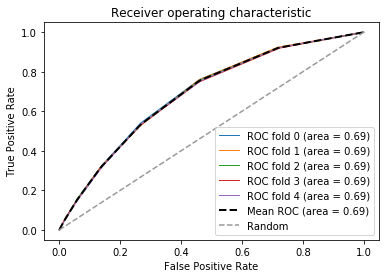

In [14]:
plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=10, max_features=20)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

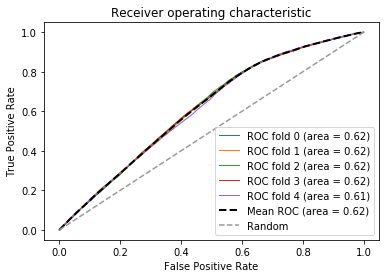

In [17]:
plot_roc(X, y, LogisticRegression, 'Logistic_Regression')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


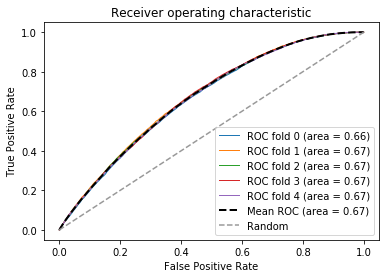

In [12]:
plot_roc(X, y, GradientBoostingClassifier, 'Gradient_Boosting')

In [18]:
data

,release_speed,release_pos_x,release_pos_z,zone,stand,p_throws,balls,strikes,pfx_x,pfx_z,...,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,fast ball,offspeed,breaking
0,79.6,-1.9574,6.2977,2.0,1,1,3,2,0.9823,-0.8014,...,54.6449,84,7,4,4,0,0,0,0,1
1,78.2,-2.2382,6.0700,12.0,0,1,0,1,1.9456,0.7637,...,55.7564,63,2,3,3,0,0,0,0,1
2,84.0,2.0231,6.4508,5.0,1,0,0,0,-0.3098,0.4272,...,55.3947,39,1,2,0,0,0,0,0,1
3,86.5,-0.3244,6.8074,8.0,1,1,2,1,0.0353,0.4745,...,54.4286,36,4,2,1,1,0,0,0,1
4,80.0,-1.7519,5.9376,7.0,0,1,1,1,0.3212,-0.9366,...,54.9763,35,3,3,3,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,87.8,-1.4583,6.4755,2.0,0,1,1,1,0.2605,0.7106,...,54.4534,12,3,0,0,0,0,1,0,0
4809,92.7,-0.9541,6.5946,13.0,1,1,0,1,-1.0402,1.4334,...,55.4399,9,2,3,0,0,0,1,0,0
4810,92.2,-2.5181,5.0753,12.0,1,1,2,2,-0.7572,1.3019,...,54.2988,7,5,1,0,0,1,1,0,0
4811,95.4,-2.2056,5.9545,6.0,0,1,1,2,-0.7903,0.8964,...,54.3803,6,4,0,0,0,0,1,0,0
